In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.special import gammaln
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm
import scipy.stats as st
from sklearn.linear_model import PoissonRegressor
import pyreadr
np.random.seed(42)
# matplotlibで日本語を使えるように
plt.rcParams["font.family"] = "IPAGothic"

In [2]:
data3a = pd.read_csv("../chapter3/data3a.csv")

<h1>5 一般化線形モデルの尤度比検定と検定の非対称性</h1>

この本では統計モデルによる推定・予測を重視する方向性なのでAICによるモデル選択と同様に、検定は推定された統計モデルを比較する方法のひとつにすぎません。  
この章ではどのような統計モデルでも利用可能な尤度比検定について学びます。  
尤度比検定はどのような統計モデルであって、逸脱度の差に注目してネストしているモデルたちを比較できます。  

<h1>5.1 統計学的な検定のわくぐみ</h1>

ネストしているパラメータの少ないモデルと多いモデルの二つを比較します。  
統計学的な検定ではそれぞれ帰無仮説、対立仮説と呼びます。帰無仮説とは「棄却されるための仮説」であり、「無に帰される」時にその役割を果たす特殊な統計モデルという位置づけです。  
統計モデルの検定では、「帰無仮説は正しい」という命題が否定できるかどうか、その点だけを調べます。  
まず、モデルのあてはまりのよさ等を検定統計量に指定します。  
次に帰無仮説が「真のモデル」であると仮定して、そのときに検定統計量の理論的なばらつきを調べて検定統計量がとりうる「ありがちな範囲」を定めます。この「ありがちな範囲」の大きさが95%である場合は、5%の有意水準を設定したと言います。  
最後に対立仮説のモデルで得られた検定統計量が、この「ありがちな範囲」からはみ出ているかどうかを確認し、もしはみ出ていれば帰無仮説は棄却され、対立仮説が支持されたと結論されます。この検定の枠組みをNeyman-Pearsonの検定の枠組みといいます。

<h1>5.2 尤度比検定の例題:逸脱度の差を調べる</h1>

今回の例題では、第三章で使った種子数データを使います。  
使用するモデルは$λ_i=exp(\beta_1+\beta_2x_i)$を平均とするポアソン回帰モデルです。  
ネストしている一定モデルと$x$モデルを比較して帰無仮説となる一定モデルが棄却できるかどうかを調べます。  
・一定モデル: 種子数の平均$λ_i$が定数であり、体サイズ$x_i$に依存しないモデル(傾き$\beta_2=0$, パラメータ数$k=1$)  
・$x$モデル:  種子数の平均$λ_i$が体サイズ$x_i$に依存するモデル(傾き$\beta_2\neq0$, パラメータ数$k=2$)  
この二つのモデルのポアソン回帰の結果は以下のようになります。  
| モデル | パラメータ数k | 尤度($logL^*$) | 逸脱度($-2logL^*$) | 残差逸脱度 | AIC |
|------|-------|------|-------|------|-------|
| 一定 | 1 | -237.6 | 475.3 | 89.5 | 477.3 |
| x | 2 | -235.4 | 470.8 | 85.0 | 474.8 |
| フル | 100 | -192.9 | 385.8 | 0.0 | 585.8 |  

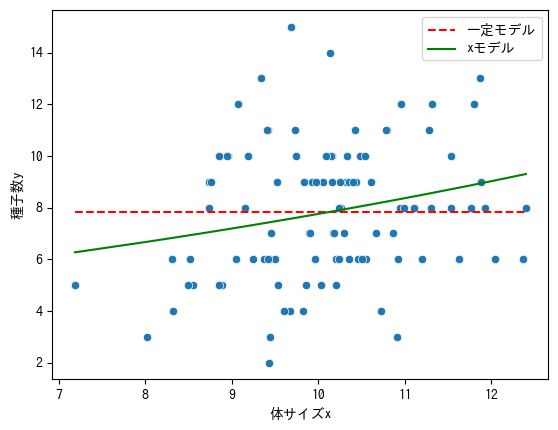

In [3]:
preds = {}
models = {}
# 説明変数に切片を追加
X = sm.add_constant(data3a[["x"]])
# 切片項のみのポアソン回帰
model = sm.GLM(data3a["y"], X["const"], family=sm.families.Poisson()).fit()
models["一定モデル"] = model
preds["一定モデル"] = model.predict(X["const"])
# 説明変数に体サイズxを含めたポアソン回帰
model = sm.GLM(data3a["y"], X, family=sm.families.Poisson()).fit()
models["xモデル"] = model
preds["xモデル"] = model.predict(X)

# グラフを描写
sns.scatterplot(data3a,x="x",y="y")
x_sorted_idx = np.argsort(X["x"])
plt.plot(X["x"].iloc[x_sorted_idx], preds["一定モデル"].iloc[x_sorted_idx],
          linestyle="--",color="red",label="一定モデル")
plt.plot(X["x"].iloc[x_sorted_idx], preds["xモデル"].iloc[x_sorted_idx],
         color="green",label="xモデル")
plt.xlabel("体サイズx")
plt.ylabel("種子数y")
plt.legend(loc="upper right")
plt.show()

逸脱度を比較すると、一定モデルが475.3でxモデルが470.8であり逸脱度の差は4.5ぐらいです。  
ネストしたモデルでは第4章で見たように同じデータに対して、パラメータ数の多いモデルの方が常に逸脱度は小さくなります。  
この検定では尤度比というものを扱います。尤度比はこの例題の場合だと以下のようになります。  
$\frac{L_1^*}{L_2^*}=\frac{一定モデルの最大尤度:exp(-237.6)}{xモデルの最大尤度:exp(-235.4)}$  
この尤度の対数を取り、-2をかけて逸脱度に変換します。  
$ΔD_{1,2}=-2(logL_1^*-logL_2^*)$  
この二つのモデルの逸脱度の差を検定統計量として使います。  
ここでの例題データでは一定モデルとxモデルの逸脱度の差は$ΔD_{1,2}=4.5$ぐらいとなっていました。  
尤度比検定では検定統計量であるこの逸脱度の差が「4.5ぐらいでは改善されていない」と仮説を立て、  
それを棄却できるかどうかを調べていきます。  

<h1>5.3 2種類の過誤と統計学的な検定の非対称性</h1>

Neyman-Pearsonの検定の枠組みでは、比較するモデルを帰無仮説と対立仮説に分類します。  
この例題の場合だと帰無仮説、対立仮説を以下のように設定します。  
・帰無仮説: 一定モデル(パラメータ数$k=1$, $\beta_2=0$)  
・対立仮説: xモデル(パラメータ数$k=2$, $\beta_2\neq0$)  
このように帰無仮説、対立仮説を設定すると「帰無仮説が正しくなければ対立仮説は正しい」あるいは「対立仮説が正しくなければ帰無仮説が正しい」が成立するような気がします。これはNeyman-Pearsonの検定の枠組みでは正しくありません。  
この点にはついては5.5節で説明するので一度気にしないことにして、この分類の下で予期される二種類の過誤が以下になります。 
|↓真のモデルは|帰無仮説を棄却|帰無仮説を棄却できない|
----|----|----|
|帰無仮説のモデルである|第一種の過誤|(問題なし)|
|対立仮説のモデルである|(問題なし)|第二種の過誤|  
  
・第一種の過誤: 真のモデルが帰無仮説で、データが一定モデルから生成されたのに「帰無仮説は正しくない」と判断する。  
・第二種の過誤: 真のモデルが対立仮設で、データがxモデルから生成されたのに「帰無仮説は正しい」と判断する。  
この二つの過誤はトレードオフの関係にあり、両方の過誤の確立を小さくすることは困難です。
    
第一種の過誤の検討にだけ専念するのがNeyman-Piersonの検定の枠組みの要点になります。  
第一種の過誤の検討にのみ専念すると、尤度比検定で必要とされる計算はずいぶんと簡単になります。この例題の場合、全体の流れは以下のようになります。  
1、帰無仮説である一定モデルが正しいものだと仮定する  
2、観測データに一定モデルをあてはめると、$\hat\beta_1=2.06$となったのでこれは真のモデルと同じだと考える  
3、この真のモデルからデータを何度も生成し、その度に帰無仮説と対立仮設のモデルをあてはめれば、たくさんの対数尤度比$ΔD_{1,2}$が得られるので$ΔD_{1,2}$の分布がわかる。  
4、そうすれば、一定モデルとxモデルの逸脱度の差が$ΔD_{1,2} \ge 4.5$となる確率が評価できるようになる。  
この設定の下で、$ΔD_{1,2}=4.5$があり得ない値だとみなされた場合に帰無仮説は棄却され、残された対立仮説が採択されます。  
このような第一種の過誤の重視は検定の非対称性と呼ばれています。  



<h1>5.4 帰無仮説を棄却するための有意水準</h1>

一定モデルとxモデルの逸脱度の差が$ΔD_{1,2} \ge 4.5$となる確率$P$は$P$値と呼ばれます。  
・$P$値が「大きい」: $ΔD_{1,2}=4.5$はよくあること→帰無仮説は棄却できない  
・$P$値が「小さい」: $ΔD_{1,2}=4.5$はとても珍しいこと→帰無仮説を棄却して残ったxモデルを採用  
  
それではこの$P$値が「大きい」「小さい」はどうやって判断すればよいのでしょうか  
Neyman-Pearsonの検定の枠組みでは有意水準$α$という値を事前に決めておいて、  
・$P \ge α$: 帰無仮説は棄却できない  
・$P < α$: 帰無仮説は棄却できる  
として判定されます。よく使われる$α=0.05$であり「めったにないこととは、20回のうち1回より少ない発生件数である」と考えて検定が行われます。  

<h2>5.4.1 方法(1)汎用性のあるパラメトリックブートストラップ法</h2>

「帰無仮説:一定モデルが真のモデルである世界」において検定統計量である$ΔD_{1,2}$が4.5より大きくなる確率(第一種の過誤の確立)を計算する方法を考えていきます。  
この項では、いかなる面倒な状況でも必ず$P$値が計算できるPB法(パラメトリックブートストラップ法)を見ていきます。  
PB法とはシミュレーションによりデータを生成して、とある推定量を計算する方法です。  
ここでは検定統計量である$ΔD_{1,2}$を推定していきます。  
1、帰無仮説を真のモデルとして、真のモデルから100個分のデータを新しく生成する。  
2、新しく生成したデータにおいて帰無仮説、対立仮設それぞれのモデルで逸脱度を計算する。  
3、帰無仮説、対立仮説の逸脱度の差を計算する。  
4、このステップを1000回ほど繰り返すと「検定統計量の確率分布」、この例題でいうと「逸脱度の差$ΔD_{1,2}$の確率分布」を予測できます。  
実際に実行して逸脱度の差$ΔD_{1,2}$を推定してみます。

PB法によるP値:  0.031
逸脱度の差の95%点:  3.801360810946873


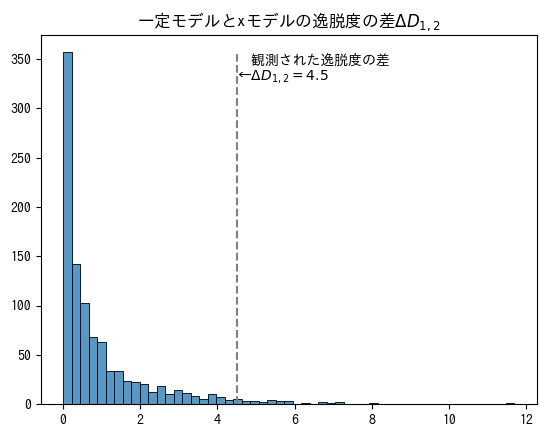

In [4]:
lam = np.exp(2.06) # 帰無仮説の一定モデルのλの推定値
k_deviances = [] # 一定モデルの逸脱度を格納(帰無仮説)
t_deviances = [] # xモデルの逸脱度を格納(対立仮設)

# 説明変数に切片を追加
X = sm.add_constant(data3a["x"])

# PB法により一定モデルとxモデルの逸脱度の差を推定する
for i in range(1000):
  y = np.random.poisson(lam=lam, size=100)
  # 一定モデルの残差逸脱度を計算
  model = sm.GLM(y, X["const"], family=sm.families.Poisson()).fit()
  k_deviances.append(model.deviance)
  # xモデルの残差逸脱度を計算
  model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
  t_deviances.append(model.deviance)
# 逸脱度の差を計算
diff_deviances = np.array(k_deviances) - np.array(t_deviances)
deviance_df = pd.DataFrame({"k_dev": k_deviances,
                            "t_dev": t_deviances,
                            "diff_dev": diff_deviances,})
# 逸脱度の差が4.5以上の確立
print("PB法によるP値: ",(deviance_df["diff_dev"]>=4.5).sum()/len(deviance_df))
print("逸脱度の差の95%点: ", deviance_df["diff_dev"].quantile(0.95))
# 逸脱度の差のヒストグラムを表示
ax = sns.histplot(deviance_df["diff_dev"])
# ヒストグラムの最大値を取得
heights = [p.get_height() for p in ax.patches]
max_count = max(heights)
plt.vlines(x=4.5, ymin=0, ymax=max_count, color="gray",linestyle="--")
plt.text(x=4.5, y=max_count, s="  観測された逸脱度の差\n←"+r"$ΔD_{1,2}=4.5$",va="top",ha="left")
plt.title(r"一定モデルとxモデルの逸脱度の差$ΔD_{1,2}$")
plt.xlabel("")
plt.ylabel("")
plt.show()

上の結果を見るとPB法により求めた$P$値は有意水準$α=0.05$より小さいので今回の検定では「帰無仮説(一定モデル)は棄却され、対立仮説(xモデル)が残るのでこれを採択」と判断します。

<h2>5.4.2 χ²分布を使った近似計算法</h2>

ここでは逸脱度の差が$χ^2$分布に従うと仮定する近似的な尤度比検定を使います。  
逸脱度の差$ΔD_{1,2}$の確率分布は自由度=(対立仮説のパラメータ数-帰無仮説のパラメータ数)の$χ^2$分布で近似できる場合があります。  
下の結果を見ると逸脱殿の差$ΔD_{1,2}$が4.5になる$P$値は$α=0.05$以下であるため帰無仮説は棄却されます。  

In [ ]:
# 説明変数に切片を追加
X = sm.add_constant(data3a["x"])
# 一定モデルの残差逸脱度を計算
model_k = sm.GLM(data3a["y"], X["const"], family=sm.families.Poisson()).fit()
# xモデルの残差逸脱度を計算
model_t = sm.GLM(data3a["y"], X, family=sm.families.Poisson()).fit()

# 逸脱度の差を計算
diff_deviance = model_k.deviance - model_t.deviance
# パラメータ数の差を計算
diff_df = model_t.df_model - model_k.df_model
# χ²分布で近似する
kai = st.chi2.cdf(diff_deviance, diff_df)
# 上側確立p値を計算
p_value = 1 - kai

print("逸脱度の差: ", diff_deviance)
print("自由度の差: ", diff_df)
print("P値: ", p_value)

逸脱度の差:  4.513941078851744
自由度の差:  1
P値:  0.033619691008986985


$χ^2$分布近似はサンプルサイズが大きい場合に有効な近似計算であり、この例題の植物の個体数は100にすぎないので  
近似的に得られた$P$値はあまり正確ではない可能性があります。  
観測された個体数が少ない場合にはPB法を使って逸脱度の差をシミュレーションで見積もる方がよいでしょう。  
  
もしデータのばらつきがポアソン分布ではなく等分散正規分布に従うと考えられる場合には、  
平均の差を検定統計量とする場合には$t$分布、分散比を検定統計量とする場合には$F$分布を使うことができます。

<h1>5.5 「帰無仮説を棄却できない」は「差がない」ではない</h1>

この例題では、観測データを得る前にあらかじめ$α=0.05$と定めておいて、尤度比検定の考え方に従って$ΔD_{1,2}$の分布を予測し、
その結果として帰無仮説が棄却されたので残された対立仮説を採択しました。  
もし仮に$P \ge α$となった場合には「帰無仮説は棄却できない」と結論付けられます。これは「帰無仮説が正しい」という意味ではありません。帰無仮説、対立仮説のどちらも正しいとも正しくないとも言えない、つまり判断を保留するということになります。  
  
尤度比検定に限らず、Neyman-Pearsonの枠組みでは「帰無仮説が棄却できないときは帰無仮説が正しいはずだ」というのは検定の誤用になります。  
Neyman-Pearsonの枠組みの検定には非対称性があるので$P<α$となった場合と$P \ge α$となった場合では「結論できること」がずいぶんと違います。  
  
Neyman-Pearsonの検定の枠組みでは第一種の過誤の確立の場合と異なり、第二種の過誤の確立を使って何かを定量的に主張する手続きは用意されていません。  
第二種の過誤の確立を$P_2$とすると、これは「帰無仮説が間違っていた時に採択してしまう確率」になります。  
これを使って$1-P_2$なる確率を定義すると、これは「帰無仮説が間違っていた時に正しく棄却できる確率」になり、検定の検出力と呼ばれます。  
一般に統計的な検定によって帰無仮説を棄却するための実験では、この検出力を高めるための実験計画が設計されます。  
検出力を高めるためには、サンプルサイズを大きくといった方法があります。

<h1>5.6 検定とモデル選択、そして推定された統計モデルの解釈</h1>

尤度比検定とAICによるモデル選択はどちらも逸脱度という統計量に注目しています。しかし、これら二つのモデル比較方法はその目的が全く異なっています。  
AICによるモデル選択では「良い予測をするモデル」を選ぶという目的を持ち、「予測の良さとは平均対数尤度」と明示した上で、平均対数尤度を最大対数尤度とバイアス(パラメータ数)から推定します。  
一方で尤度比検定などNeyman-Pearsonの枠組みの下での統計学的な検定の目的は「帰無仮説の安全な棄却です」。帰無仮説が棄却された後に残された対立仮説がどのような意味で良いモデルなのかは明確ではありません。  
検定にせよモデル選択にせよ「有意でした」「このモデルのAICが最小でした」と述べるだけで自分の主張が正当化されるわけではありません。  
  
統計的な有意差とはある要因の効果の大小そのものを直接にあらわすものではなく、サンプルサイズによって$P>α$となったりAIC最小モデルとなることもあります。$P$値は効果の大きさそのものをあらわすものではありません。  
推定された統計モデルの解釈は、推定されたパラメータがどのような値であり、標準誤差などであらわされる推定の誤差がどれほどなのか、それらを組み合わせた時の統計モデルの挙動はどうなると予測されるのかも示すべきでしょう。

<h1>5.7 この章のまとめ</h1>

この章では、データ解析でよく使われている検定の枠組みについて再度確認しました。  
・Neyman-Pearsonの統計的検定の枠組みでは、パラメータ数の少ないモデルを帰無仮説と位置づけ、帰無仮説が棄却できるかどうかの確率評価に専念する(5.1 統計学的な検定の枠組み)  
・尤度比検定の検定統計量は二つの統計モデルの逸脱度の差である(5.2 尤度比検定の例題:逸脱度の差を調べる)  
・検定における過誤は二種類あるが、Neyman-Pearsonの検定の枠組みでは第一種の過誤を重視する(5.3 2種類の過誤と統計学的な検定の非対称性)  
・帰無仮説を棄却する有意水準$α$の大きさは解析者が任意に決めるものであり、$α=0.05$がよく使われるが何か特別な根拠に基づくものではない。(5.4 帰無仮説を棄却するための有意水準)  
・Neyman-Pearsonの検定の枠組みでは、第一種の過誤の大きさを正確に評価できるが、一方で帰無仮説が棄却できない場合の結論は何も言えない、つまり判断を保留するしかない(5.5 「帰無仮説を棄却できない」は「差がない」ではない)  
・検定やモデル選択の結果だけに注目するだけではなく、対象となる現象の挙動をどのように予測しているのかも確認しなければならない(5.6 検定とモデル選択、そして推定された統計モデルの解釈)